# Analyze Model Weights

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (20, 20), 'figure.dpi': 300}
)

## ICC - Single Result

In [5]:
from common.data import get_model_weights

population = 'adhd'
measure = 'WISC_PSI'
age_group = 'All'

pls_weights = get_model_weights('pls', population, measure, age_group)
ridge_weights = get_model_weights('ridge', population, measure, age_group)

print(pls_weights.shape, ridge_weights.shape)

(34716,) (34716,)


In [9]:
from os.path import join
from common.paths import RIDGE_WEIGHTS

weight_pop = 'adhd'
weight_tar = 'WISC_FSIQ'
weight_age = 'all'
s1_f = f'ridge_{weight_pop}_{weight_tar}_{weight_age}_set_2.npy'
s2_f = f'ridge_healthy_{weight_tar}_{weight_age}_set_1.npy'

s1 = np.load(join(RIDGE_WEIGHTS, s1_f))
s2 = np.load(join(RIDGE_WEIGHTS, s2_f))

In [6]:
%%time
import pingouin as pg

coefs = np.array([pls_weights, ridge_weights])
# coefs = np.array([s1, s2])
# print(f'{population}_{measure}_{age_group}', coefs.shape)

icc_data = pd.DataFrame(coefs).melt(var_name='connection', value_name='weight', ignore_index=False)
icc_data['cv_run_num'] = icc_data.index
icc = pg.intraclass_corr(data=icc_data, targets='connection', raters='cv_run_num', ratings='weight').round(3)
icc.set_index("Type")

/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


CPU times: user 31.7 s, sys: 276 ms, total: 32 s
Wall time: 32.2 s


Description    ICC      F    df1    df2  pval         CI95%
Type                                                                          
ICC1    Single raters absolute  0.746  6.889  34715  34716   0.0  [0.74, 0.75]
ICC2      Single random raters  0.746  6.889  34715  34715   0.0  [0.74, 0.75]
ICC3       Single fixed raters  0.746  6.889  34715  34715   0.0  [0.74, 0.75]
ICC1k  Average raters absolute  0.855  6.889  34715  34716   0.0  [0.85, 0.86]
ICC2k    Average random raters  0.855  6.889  34715  34715   0.0  [0.85, 0.86]
ICC3k     Average fixed raters  0.855  6.889  34715  34715   0.0  [0.85, 0.86]

## ICC - All Results

In [22]:
%%time
import pingouin as pg
from os.path import join
from common.data import get_model_weights
from common.wisc import FSIQ, PRIMARY_INDICES
from common.binning import BIN_LABELS
from common.paths import MODEL_RESULTS

results = []
population = 'healthy'
targets = FSIQ + PRIMARY_INDICES
age_groups = ['All']

for bin_label in age_groups:
    for target in targets:
        pls_weights = get_model_weights('pls', population, target, bin_label)
        ridge_weights = get_model_weights('ridge', population, target, bin_label)
        
        icc_data = pd.DataFrame([pls_weights, ridge_weights]).melt(
            var_name='connection', value_name='weight', ignore_index=False)
        icc_data['cv_run_num'] = icc_data.index
        icc = pg.intraclass_corr(data=icc_data, targets='connection', raters='cv_run_num', ratings='weight').round(3)
        icc1 = icc[icc['Type'] == 'ICC1'].to_dict('records')[0]
        results.append({
            'Population': population,
            'Target': target,
            'Bin': bin_label,
            **icc1,
        })
        print(results[-1])
        
results_df = pd.DataFrame(results)
display(results_df)
filename = f'between-model_icc_{population}.csv'
results_df.to_csv(join(MODEL_RESULTS, filename))

{'Population': 'healthy', 'Target': 'WISC_FSIQ', 'Bin': 'All', 'Type': 'ICC1', 'Description': 'Single raters absolute', 'ICC': 0.978, 'F': 89.228, 'df1': 34715, 'df2': 34716, 'pval': 0.0, 'CI95%': array([0.98, 0.98])}
{'Population': 'healthy', 'Target': 'WISC_VSI', 'Bin': 'All', 'Type': 'ICC1', 'Description': 'Single raters absolute', 'ICC': 0.978, 'F': 90.155, 'df1': 34715, 'df2': 34716, 'pval': 0.0, 'CI95%': array([0.98, 0.98])}
{'Population': 'healthy', 'Target': 'WISC_VCI', 'Bin': 'All', 'Type': 'ICC1', 'Description': 'Single raters absolute', 'ICC': 0.941, 'F': 33.087, 'df1': 34715, 'df2': 34716, 'pval': 0.0, 'CI95%': array([0.94, 0.94])}
{'Population': 'healthy', 'Target': 'WISC_FRI', 'Bin': 'All', 'Type': 'ICC1', 'Description': 'Single raters absolute', 'ICC': 0.976, 'F': 83.172, 'df1': 34715, 'df2': 34716, 'pval': 0.0, 'CI95%': array([0.98, 0.98])}
{'Population': 'healthy', 'Target': 'WISC_WMI', 'Bin': 'All', 'Type': 'ICC1', 'Description': 'Single raters absolute', 'ICC': 0.872

Population     Target  Bin  Type             Description    ICC       F  \
0    healthy  WISC_FSIQ  All  ICC1  Single raters absolute  0.978  89.228   
1    healthy   WISC_VSI  All  ICC1  Single raters absolute  0.978  90.155   
2    healthy   WISC_VCI  All  ICC1  Single raters absolute  0.941  33.087   
3    healthy   WISC_FRI  All  ICC1  Single raters absolute  0.976  83.172   
4    healthy   WISC_WMI  All  ICC1  Single raters absolute  0.872  14.657   
5    healthy   WISC_PSI  All  ICC1  Single raters absolute  0.977  85.075   

     df1    df2  pval         CI95%  
0  34715  34716   0.0  [0.98, 0.98]  
1  34715  34716   0.0  [0.98, 0.98]  
2  34715  34716   0.0  [0.94, 0.94]  
3  34715  34716   0.0  [0.98, 0.98]  
4  34715  34716   0.0  [0.87, 0.87]  
5  34715  34716   0.0  [0.98, 0.98]

CPU times: user 3min 8s, sys: 968 ms, total: 3min 9s
Wall time: 3min 8s


In [21]:
import pingouin as pg
from os.path import join
from common.data import get_model_weights
from common.wisc import FSIQ, PRIMARY_INDICES
from common.binning import BIN_LABELS
from common.paths import MODEL_RESULTS
        
results_df = pd.DataFrame(results)
display(results_df)
filename = f'between-model_icc_{population}.csv'
results_df.to_csv(join(MODEL_RESULTS, filename))

Population     Target    Bin  Type             Description    ICC        F  \
0        adhd  WISC_FSIQ    All  ICC1  Single raters absolute  0.955   42.974   
1        adhd   WISC_VSI    All  ICC1  Single raters absolute  0.783    8.213   
2        adhd   WISC_VCI    All  ICC1  Single raters absolute  0.932   28.405   
3        adhd   WISC_FRI    All  ICC1  Single raters absolute  0.901   19.119   
4        adhd   WISC_WMI    All  ICC1  Single raters absolute  0.895   17.973   
5        adhd   WISC_PSI    All  ICC1  Single raters absolute  0.746    6.889   
6        adhd  WISC_FSIQ  Bin 1  ICC1  Single raters absolute  0.981  102.795   
7        adhd   WISC_VSI  Bin 1  ICC1  Single raters absolute  0.900   18.949   
8        adhd   WISC_VCI  Bin 1  ICC1  Single raters absolute  0.981  103.545   
9        adhd   WISC_FRI  Bin 1  ICC1  Single raters absolute  0.980   96.743   
10       adhd   WISC_WMI  Bin 1  ICC1  Single raters absolute  0.980   99.617   
11       adhd   WISC_PSI  Bin 1  ICC1  Single raters absolute  0.419    2.445   
12       adhd  WISC_FSIQ  Bin 2  ICC1  Single raters absolute  0.967   59.322   
13       adhd   WISC_VSI  Bin 2  ICC1  Single raters absolute  0.577    3.723   
14       adhd   WISC_VCI  Bin 2  ICC1  Single raters absolute  0.961   50.537   
15       adhd   WISC_FRI  Bin 2  ICC1  Single raters absolute  0.955   43.043   
16       adhd   WISC_WMI  Bin 2  ICC1  Single raters absolute  0.969   63.620   
17       adhd   WISC_PSI  Bin 2  ICC1  Single raters absolute  0.971   68.255   
18       adhd  WISC_FSIQ  Bin 3  ICC1  Single raters absolute  0.976   83.047   
19       adhd   WISC_VSI  Bin 3  ICC1  Single raters absolute  0.872   14.599   
20       adhd   WISC_VCI  Bin 3  ICC1  Single raters absolute  0.977   85.597   
21       adhd   WISC_FRI  Bin 3  ICC1  Single raters absolute  0.930   27.586   
22       adhd   WISC_WMI  Bin 3  ICC1  Single raters absolute  0.436    2.547   
23       adhd   WISC_PSI  Bin 3  ICC1  Single raters absolute  0.978   89.387   

      df1    df2  pval         CI95%  
0   34715  34716   0.0  [0.95, 0.96]  
1   34715  34716   0.0  [0.78, 0.79]  
2   34715  34716   0.0  [0.93, 0.93]  
3   34715  34716   0.0    [0.9, 0.9]  
4   34715  34716   0.0   [0.89, 0.9]  
5   34715  34716   0.0  [0.74, 0.75]  
6   34715  34716   0.0  [0.98, 0.98]  
7   34715  34716   0.0    [0.9, 0.9]  
8   34715  34716   0.0  [0.98, 0.98]  
9   34715  34716   0.0  [0.98, 0.98]  
10  34715  34716   0.0  [0.98, 0.98]  
11  34715  34716   0.0  [0.41, 0.43]  
12  34715  34716   0.0  [0.97, 0.97]  
13  34715  34716   0.0  [0.57, 0.58]  
14  34715  34716   0.0  [0.96, 0.96]  
15  34715  34716   0.0  [0.95, 0.96]  
16  34715  34716   0.0  [0.97, 0.97]  
17  34715  34716   0.0  [0.97, 0.97]  
18  34715  34716   0.0  [0.98, 0.98]  
19  34715  34716   0.0  [0.87, 0.87]  
20  34715  34716   0.0  [0.98, 0.98]  
21  34715  34716   0.0  [0.93, 0.93]  
22  34715  34716   0.0  [0.43, 0.44]  
23  34715  34716   0.0  [0.98, 0.98]

## Plot Weights

In [2]:
import matplotlib.patches as mpatches

from common.data import get_model_weights
from common.paths import POWER
from common.plotting import create_power_fc_matrix, plot_connections
from mne.viz import circular_layout, plot_connectivity_circle
from operator import itemgetter

In [3]:
population = 'adhd'
measure = 'WISC_FSIQ'
age_group = 'All'

pls_weights = get_model_weights('pls', population, measure, age_group)
ridge_weights = get_model_weights('ridge', population, measure, age_group)

print(pls_weights.shape, ridge_weights.shape)

(34716,) (34716,)


In [4]:
selected_features = ridge_weights
print(np.min(selected_features), np.max(selected_features))

-0.026036363 0.023280866


### Glass brain

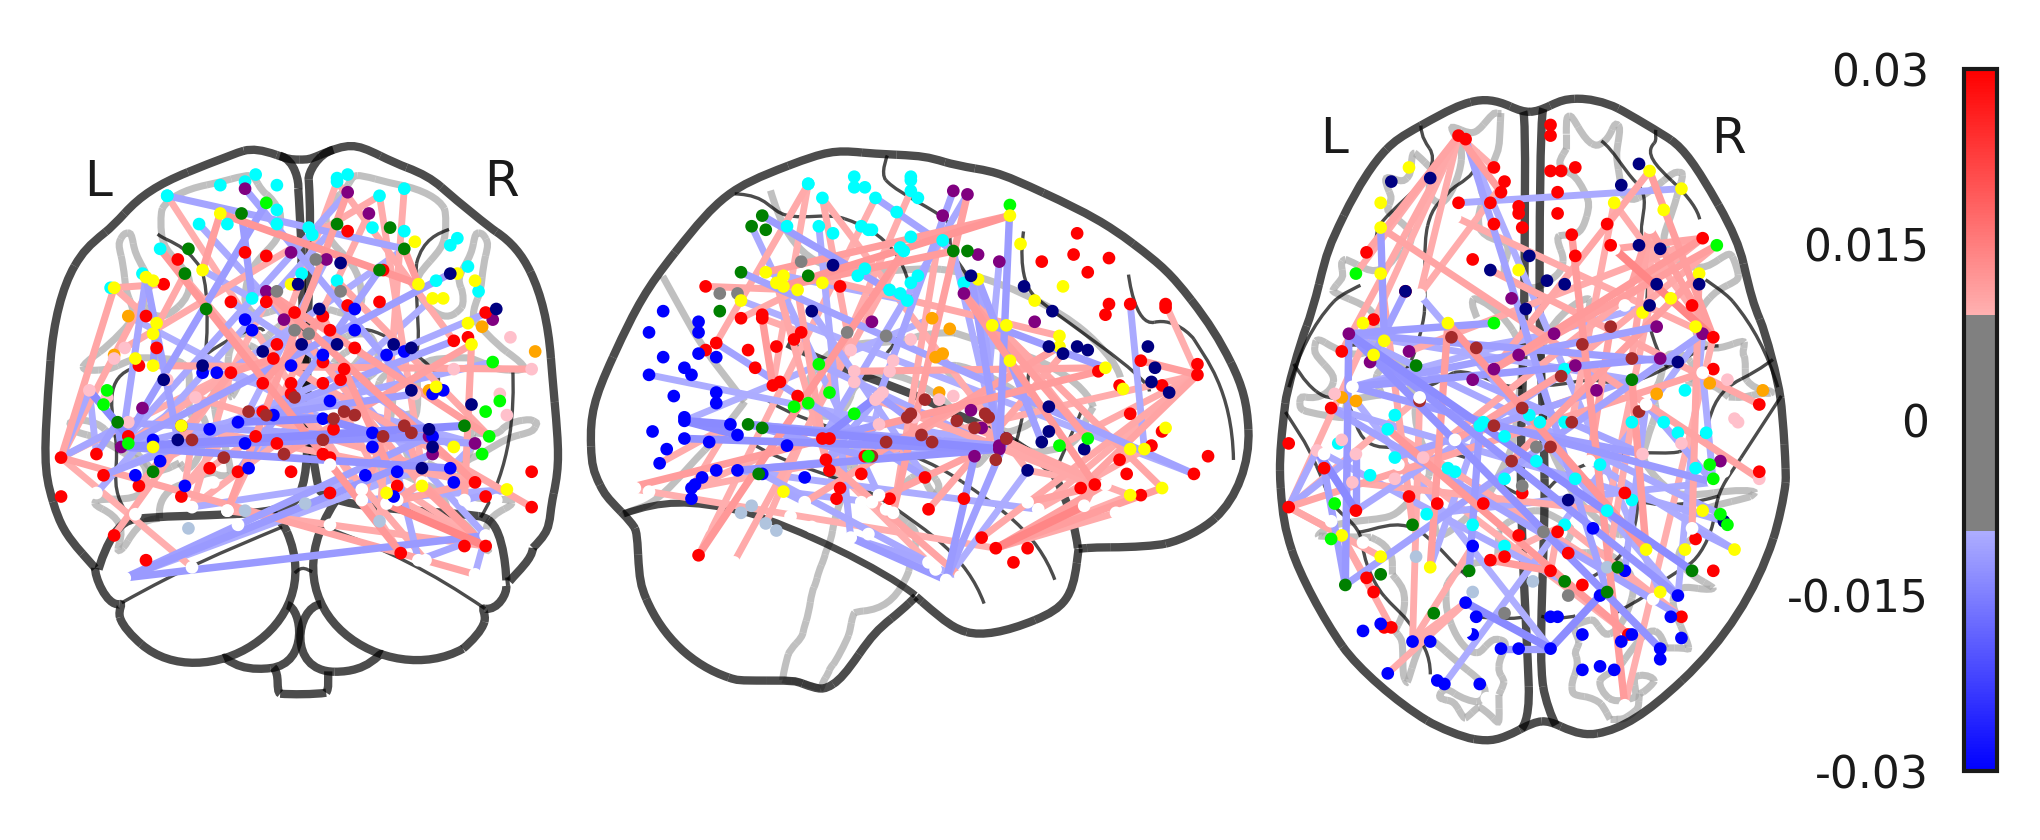

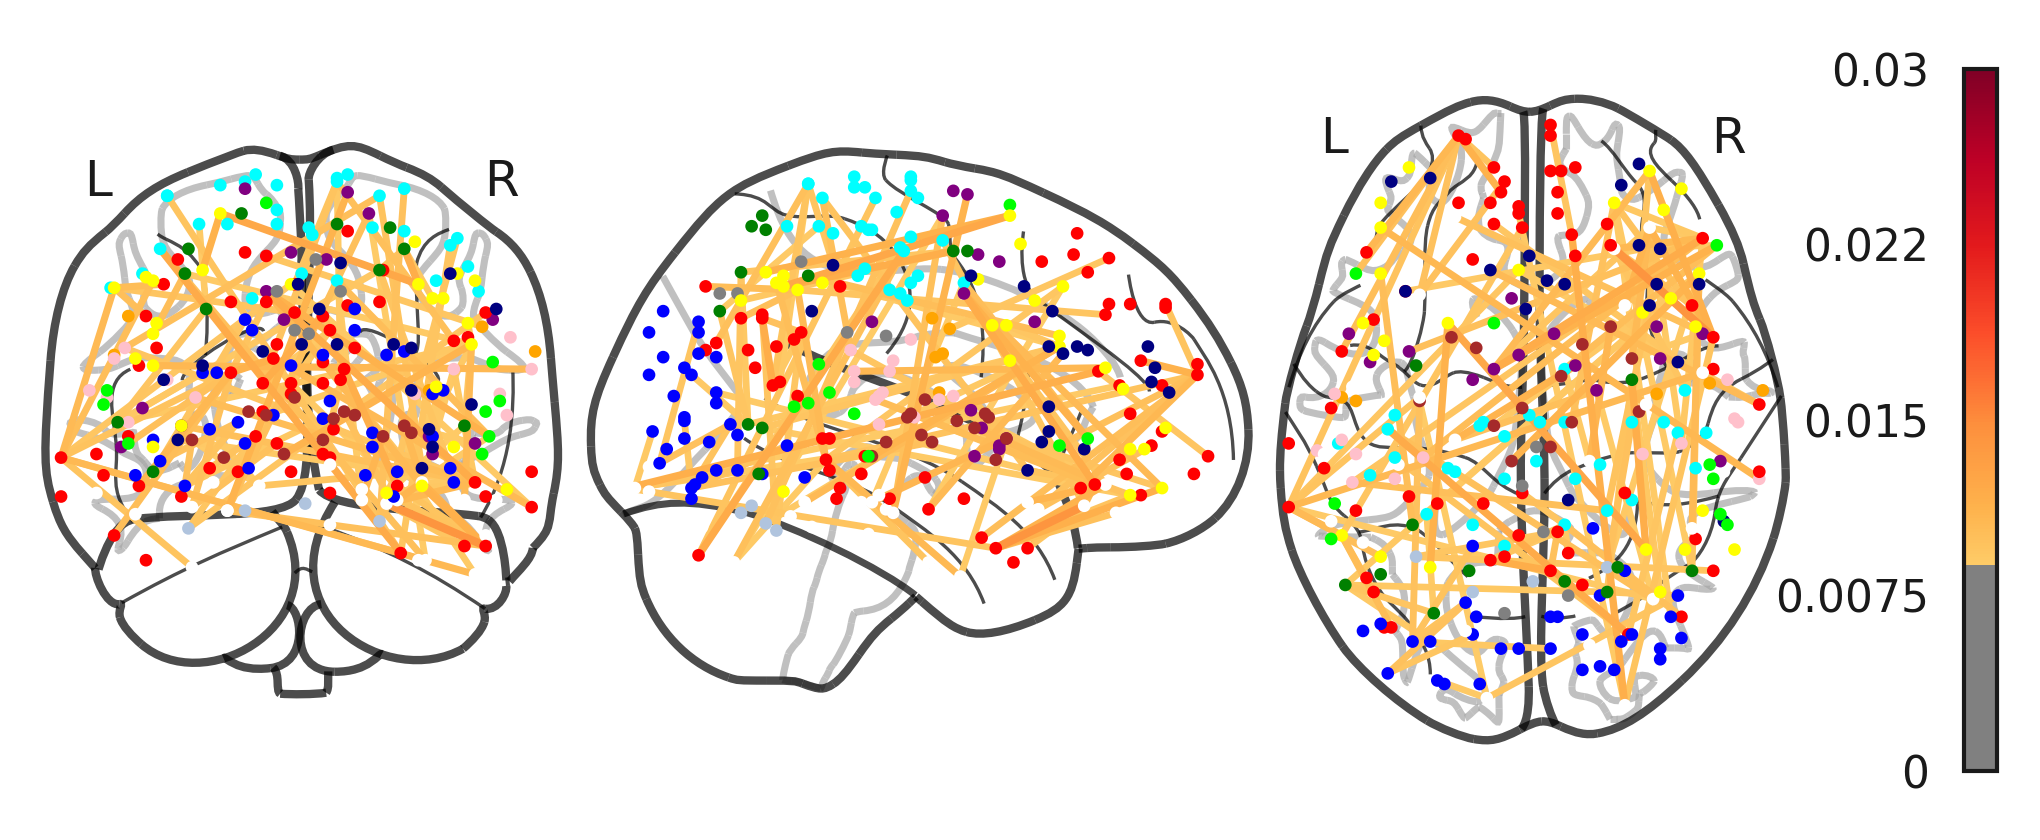

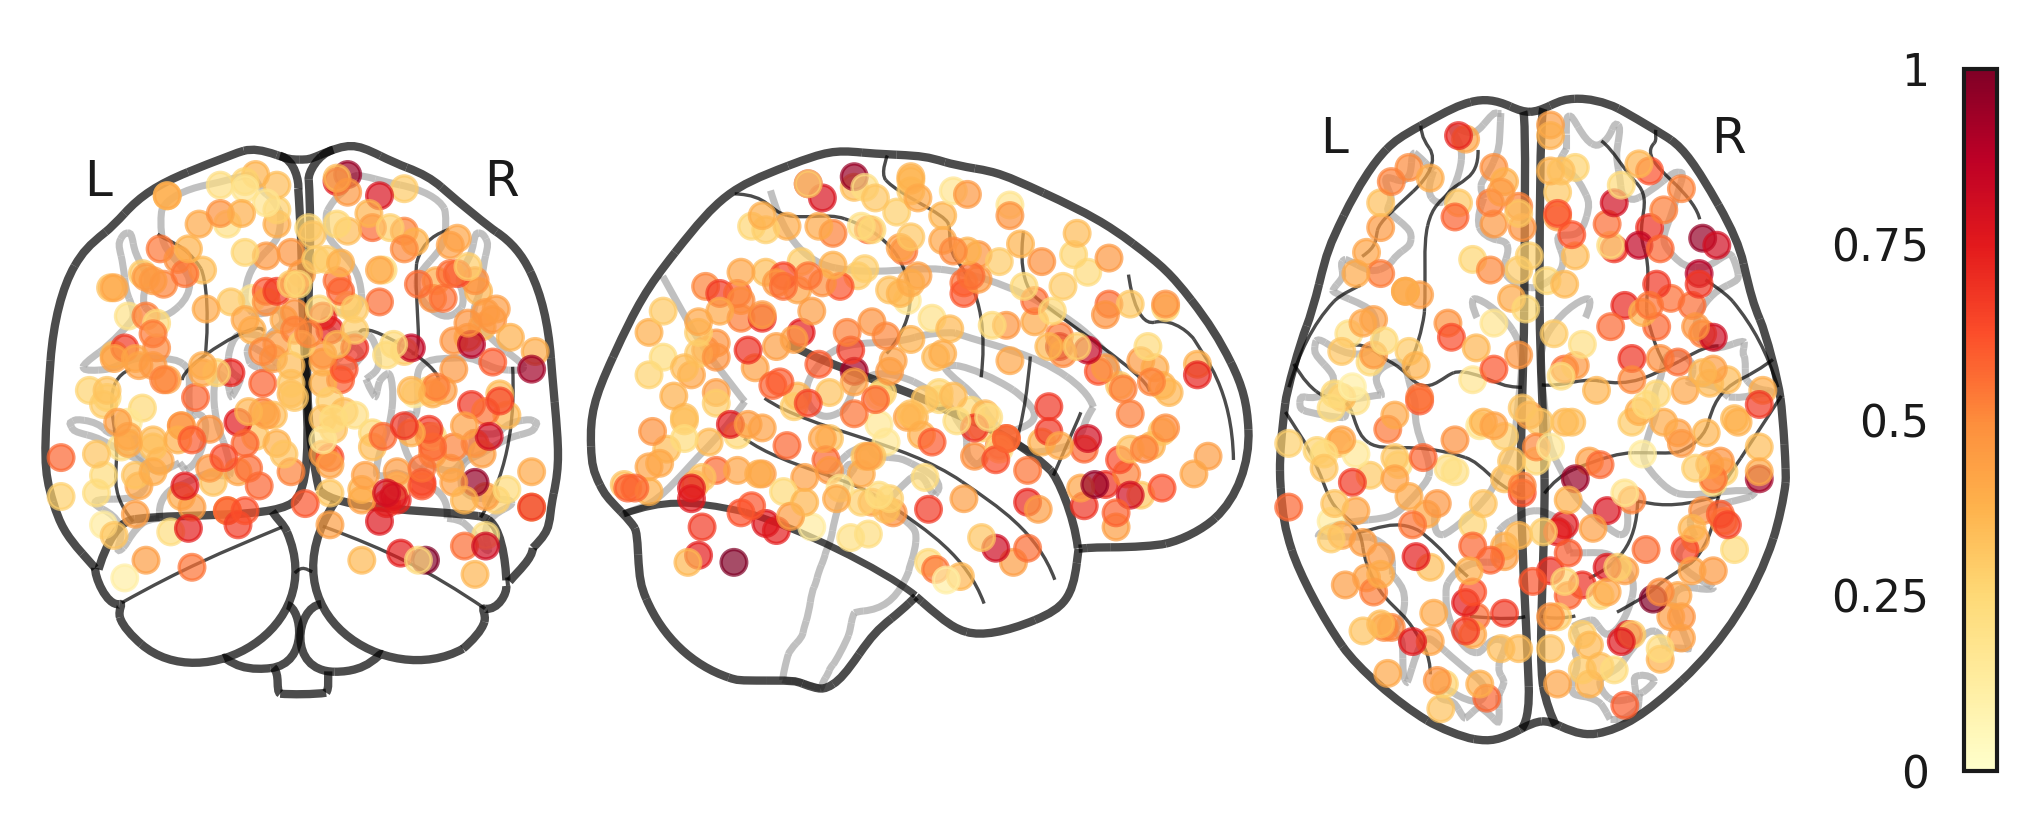

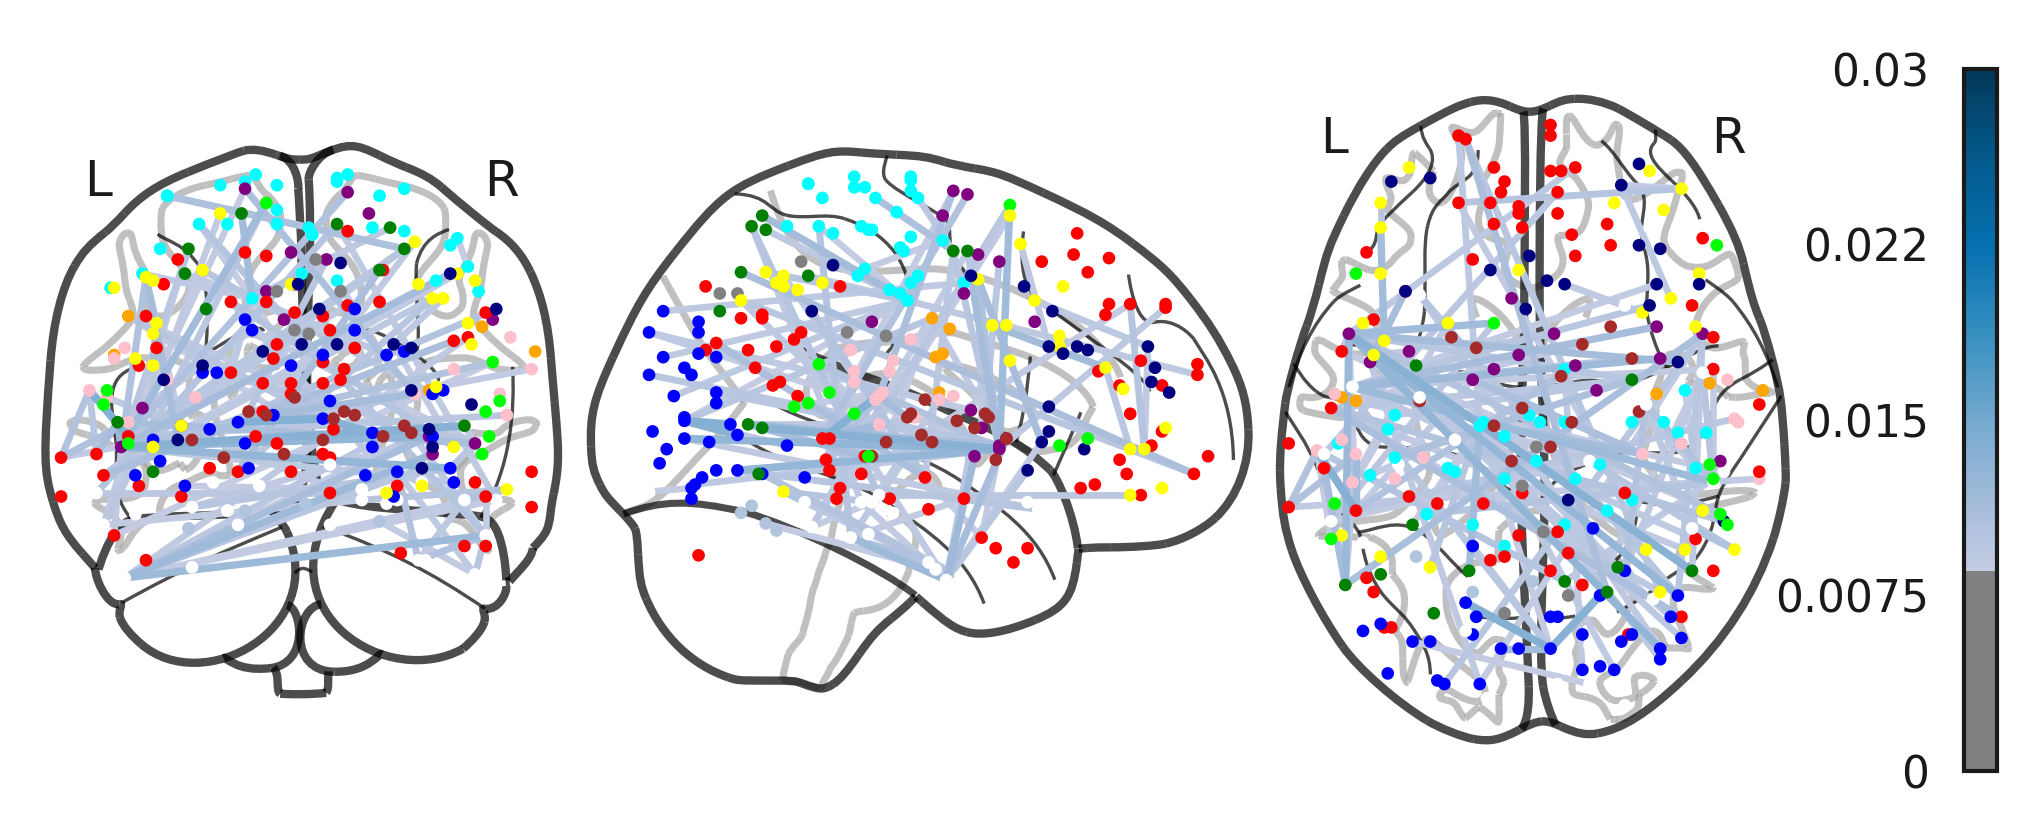

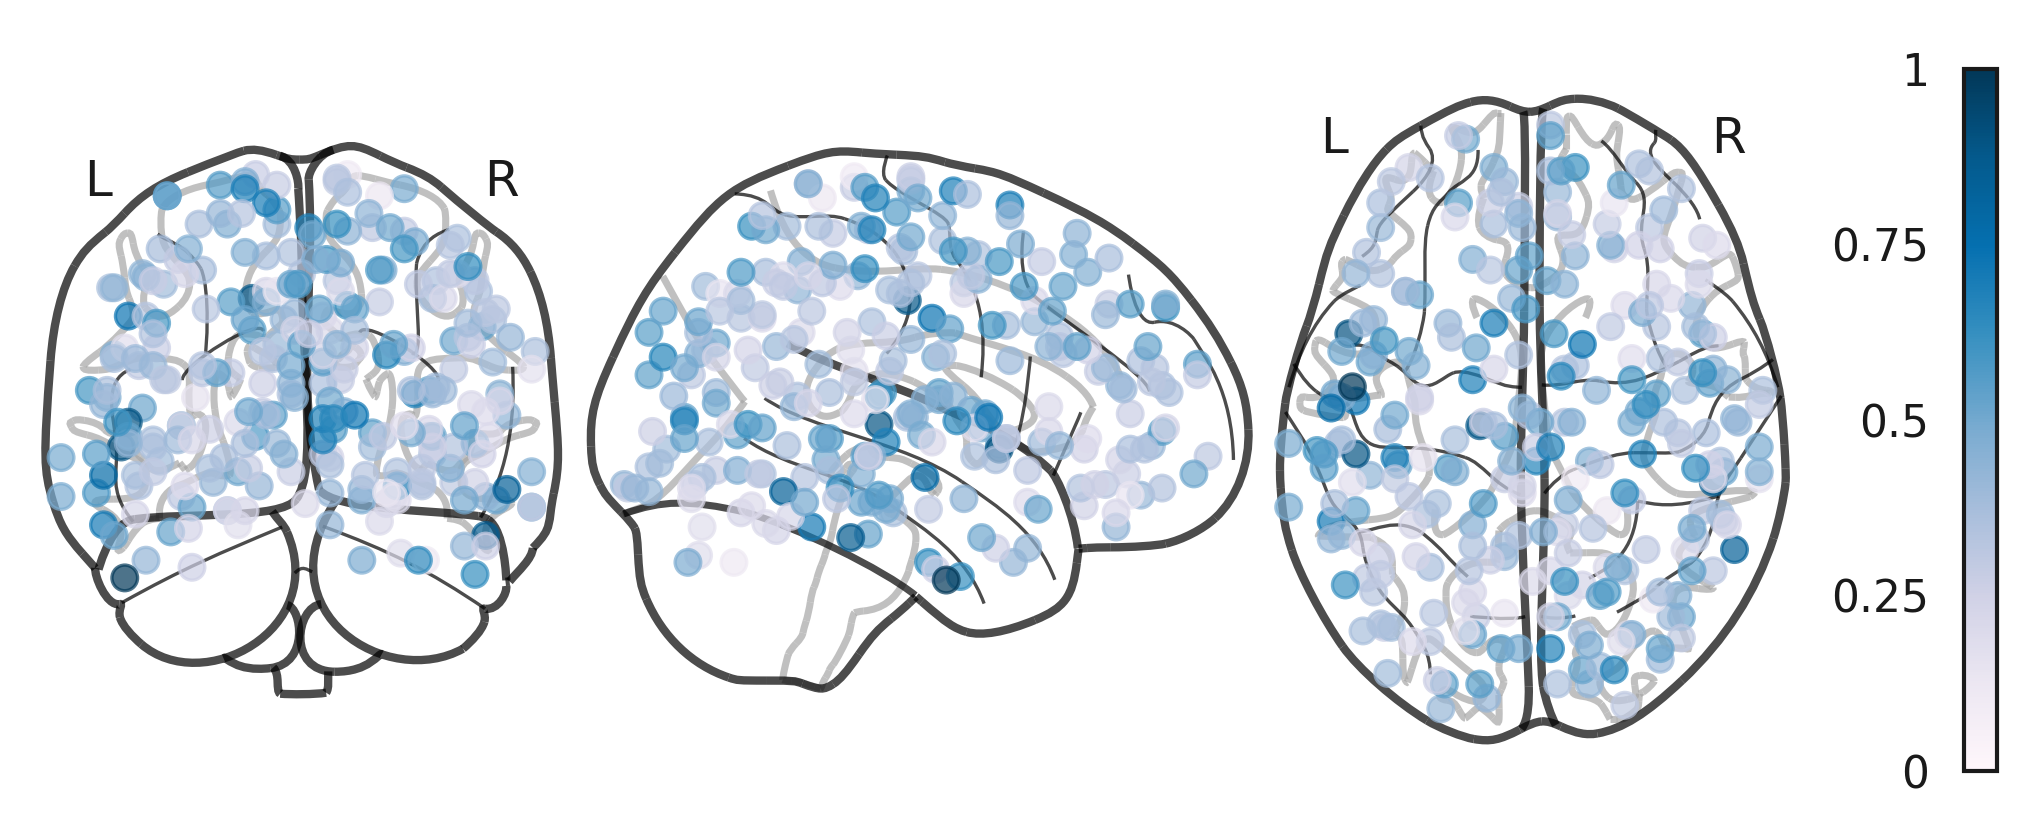

In [24]:
plot_connections(selected_features, -0.03, 0.03, True)

### Connectivity circle

In [8]:
power_labels = pd.read_csv(POWER, index_col='ROI')
node_names = [str(node_num) for node_num in range(1, 265)]
node_labels = list(zip(node_names, power_labels['Assignment']))
node_labels.sort(key=itemgetter(1))
node_order = [node[0] for node in node_labels]

num_nodes_per_system = power_labels['Assignment'].value_counts().sort_index()
group_boundaries = np.array(np.cumsum(num_nodes_per_system.values)[:-1])

node_colors = power_labels['Color'].values.tolist()

node_angles = circular_layout(node_names, node_order, group_boundaries=group_boundaries,
                              group_sep=0)

In [9]:
power_legend = power_labels[['Color', 'System']].drop_duplicates()
display(power_legend)
power_legend_patches = []
for color, system in zip(power_legend['Color'], power_legend['System']):
    power_legend_patches.append(mpatches.Patch(color=color, label=system))

Color                          System
ROI                                                
1             White                       Uncertain
13             Cyan        Sensory/somatomotor Hand
42           Orange       Sensory/somatomotor Mouth
47           Purple  Cingulo-opercular Task Control
61             Pink                        Auditory
74              Red                    Default mode
133            Gray                Memory retrieval
138            lime               Ventral attention
143            Blue                          Visual
174          Yellow    Fronto-parietal Task Control
203            navy                        Salience
222           Brown                     Subcortical
243  lightsteelblue                      Cerebellar
251           Green                Dorsal attention

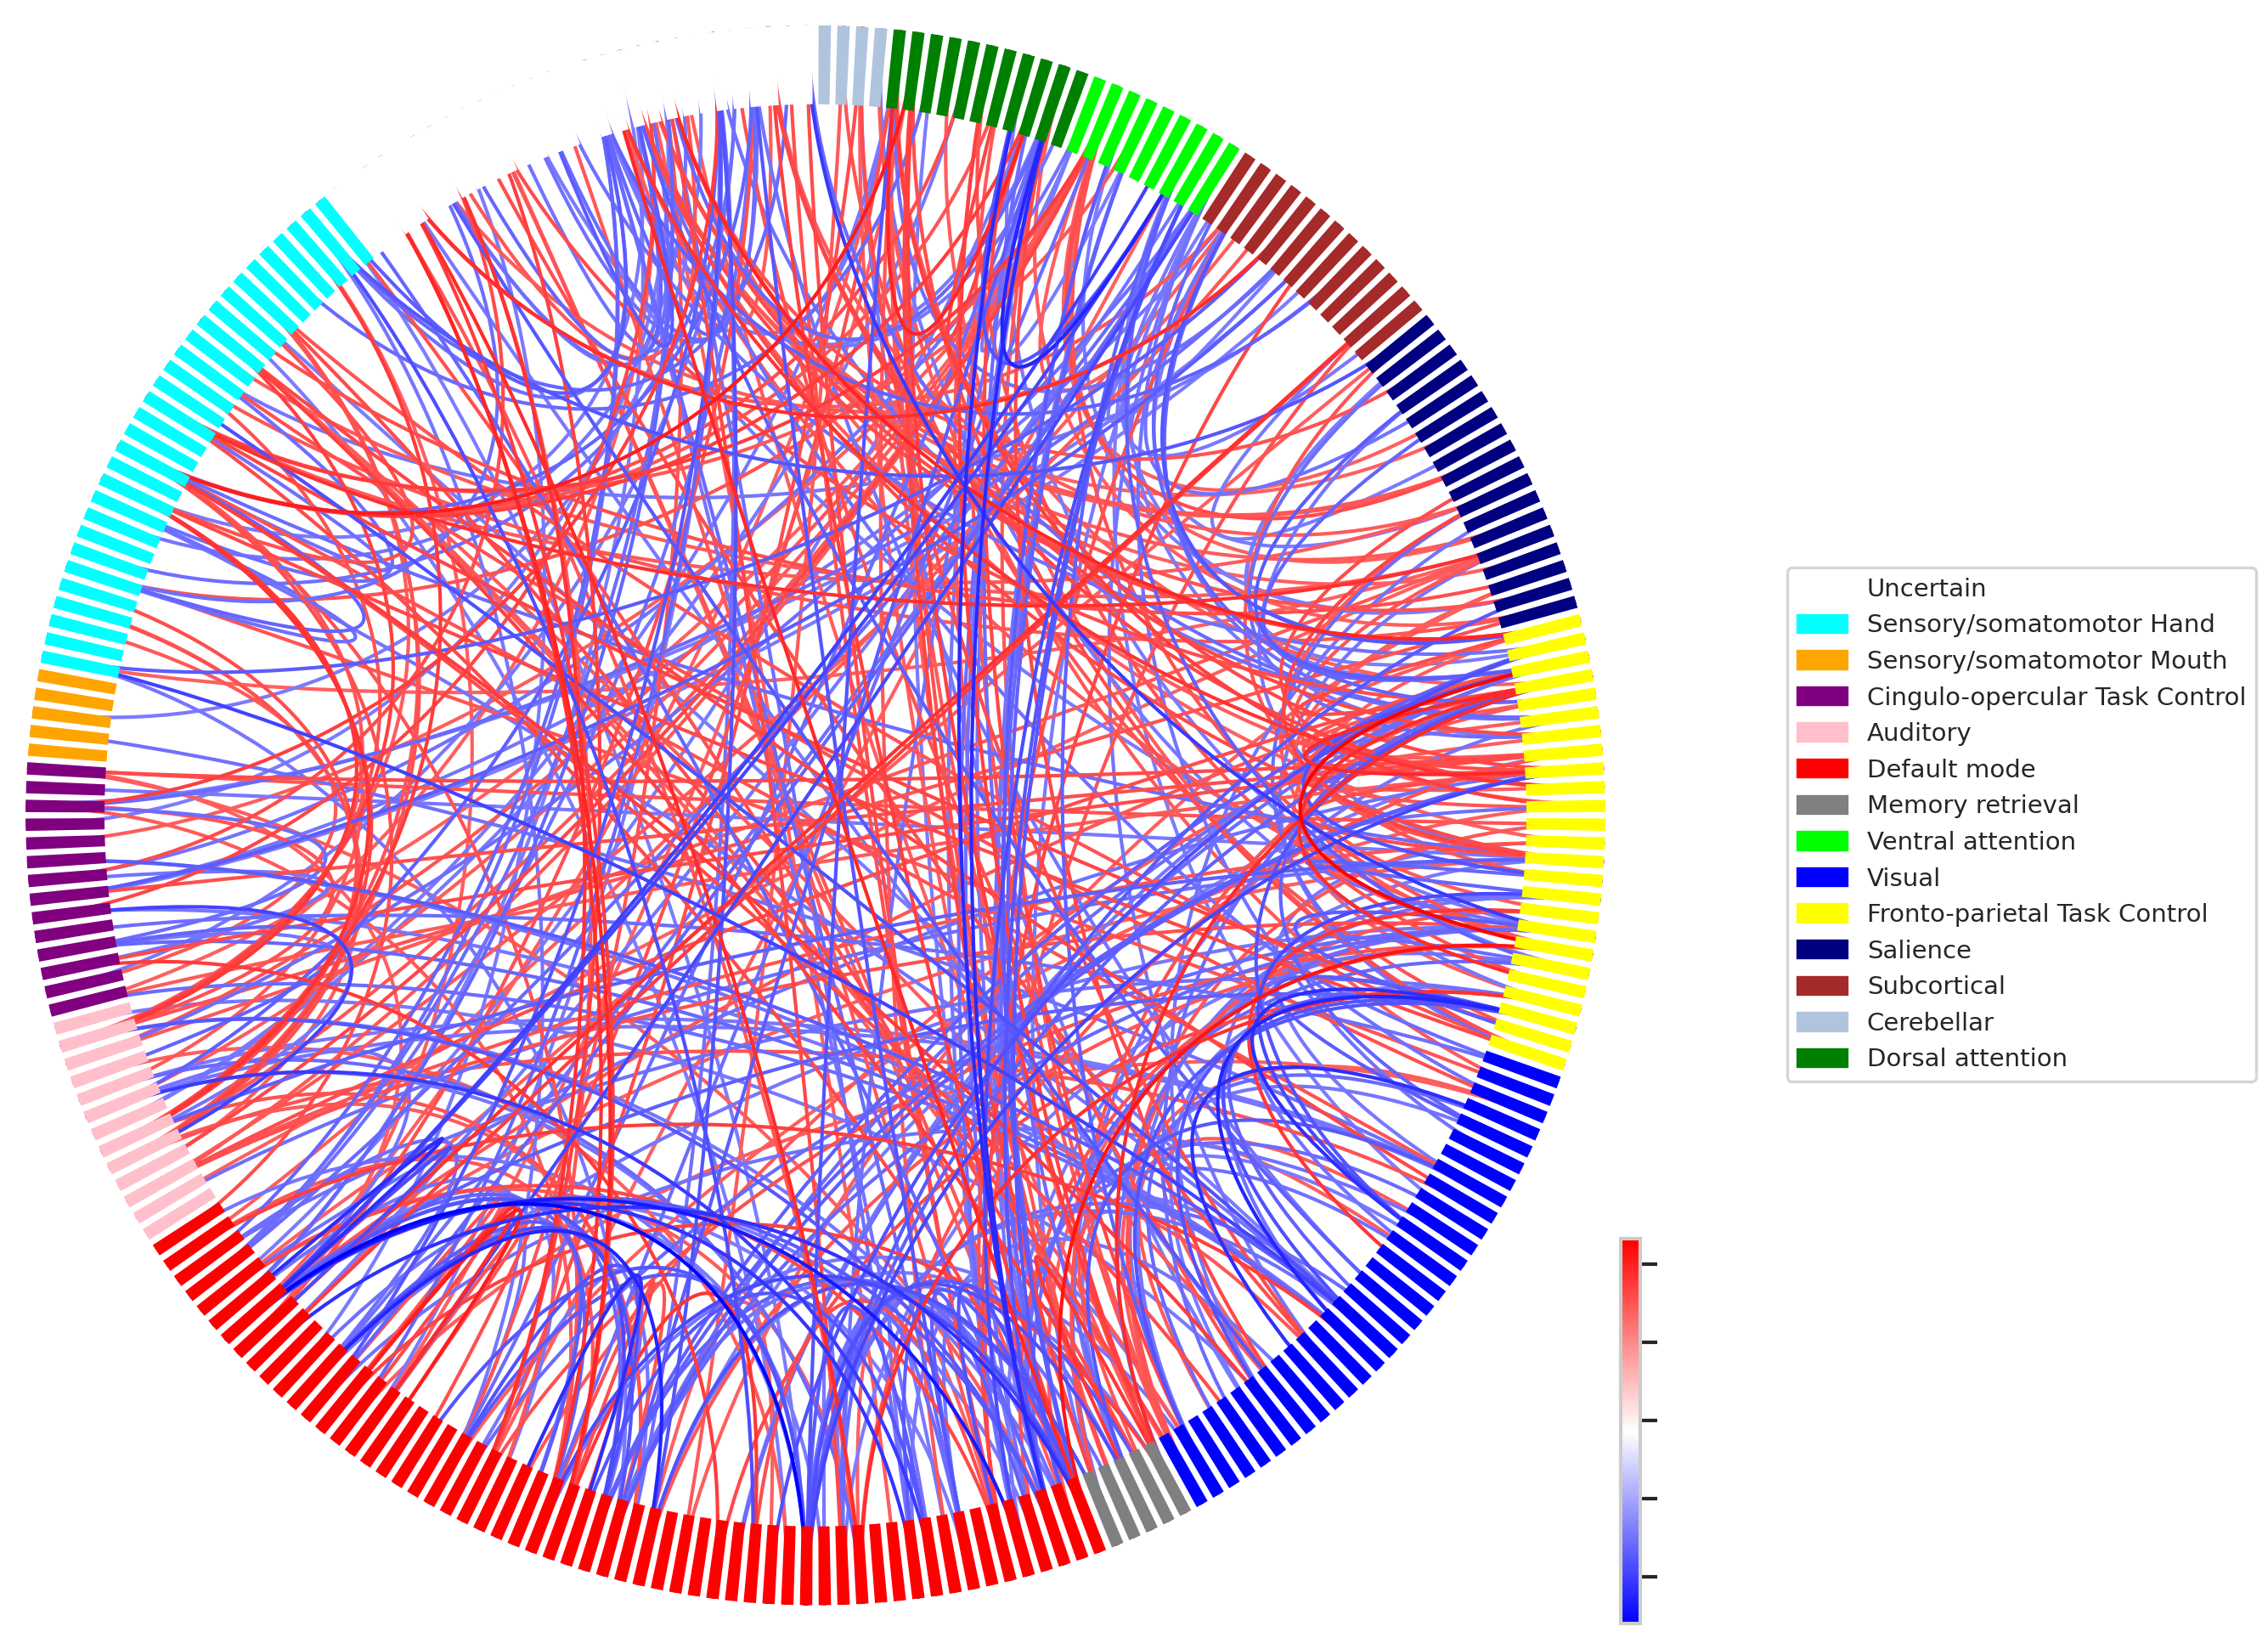

In [12]:
matrix = create_power_fc_matrix(selected_features)

plt.rc('legend',fontsize=7)
figx = plt.figure(figsize=(10, 10), facecolor=(0, 0, 0, 0))
figx.legend(handles=power_legend_patches, loc="center right")
node_names = ["" for node_num in range(1, 265)]
fig, ax = plot_connectivity_circle(matrix, node_names, n_lines=500, node_angles=node_angles, 
                         fontsize_names=4, padding=0, colormap='bwr', linewidth=1, show=True,
                         node_colors=node_colors, facecolor=(0, 0, 0, 0), node_edgecolor=(0, 0, 0, 0),
                         colorbar=True, node_width=0.9, fig=figx)

## Analyze Nodes

In [ ]:
from nilearn import plotting, datasets
from common.calculation import get_k_argmax
from common.plotting import create_power_fc_matrix, convert_fc_to_node_strength

power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T
matrix = create_power_fc_matrix(pls_coef)

# clip connectivity matrix to preserve positive and negative edges
positive_edges = np.clip(matrix, 0, matrix.max())
negative_edges = np.clip(matrix, matrix.min(), 0)

# calculate strength for positive edges
node_strength_positive = convert_fc_to_node_strength(positive_edges)

# calculate strength for negative edges
node_strength_negative = convert_fc_to_node_strength(negative_edges)

print(node_strength_positive.shape, node_strength_negative.shape)
top_pos_nodes = get_k_argmax(node_strength_positive, 10)
top_neg_nodes = get_k_argmax(node_strength_negative, 10)

print(coords[top_pos_nodes], node_strength_positive[top_pos_nodes])
print(coords[top_neg_nodes], node_strength_negative[top_neg_nodes])

plotting.plot_markers(node_strength_positive[top_pos_nodes], coords[top_pos_nodes],
                      node_vmin=0, node_vmax=1, node_cmap="YlOrRd")
plotting.plot_markers(node_strength_negative[top_neg_nodes], coords[top_neg_nodes],
                      node_vmin=0, node_vmax=1, node_cmap="PuBu")